# **Important Libraries**

In [1]:
!pip install transformers datasets evaluate accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
from transformers import (
    VideoMAEImageProcessor,
    VideoMAEForVideoClassification,
    TrainingArguments,
    Trainer,
    set_seed
)
import evaluate
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

2025-08-10 17:14:19.892618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754846060.072118      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754846060.124654      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")
wandb.login(key=secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mohamed-hishamk90 (mohamed-hishamk90-aiet) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# Config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(42)

DATA_DIR = "/kaggle/input/shoplifting-videos-dataset/Shop DataSet"  
FRAMES_PER_VIDEO = 16
FRAME_SIZE = (224, 224)  
MIN_FRAMES = 16

# **Load Datase**

In [5]:
def create_dataset(data_dir):
    filepaths = []
    labels = []
    seen_bases = set()  # track unique base names to drop duplicates 

    if not os.path.isdir(data_dir):
        raise FileNotFoundError(f"DATA_DIR not found: {data_dir}")

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if not os.path.isdir(foldpath):
            continue
        fileslist = os.listdir(foldpath)
        for file in fileslist:
            if not file.lower().endswith('.mp4'):
                continue
            filepath = os.path.join(foldpath, file)

            # Deduplicate only inside 'non shop lifters'
            if fold == 'non shop lifters':
                # Remove trailing _<number> and .mp4 to identify base name
                base_name = re.sub(r'(_\d+)?\.mp4$', '', file, flags=re.IGNORECASE)
                if base_name in seen_bases:
                    continue
                seen_bases.add(base_name)

            filepaths.append(filepath)
            labels.append(fold)

    if not filepaths:
        raise RuntimeError("No videos found. Check DATA_DIR and folder names.")
    return pd.DataFrame({"files": filepaths, "labels": labels})

df = create_dataset(DATA_DIR)
df.head()

,files,labels
0,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters
1,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters
2,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters
3,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters
4,/kaggle/input/shoplifting-videos-dataset/Shop ...,non shop lifters


# **Preprocessing**

In [6]:
# Filter videos with at least MIN_FRAMES frames
def is_long_enough(path, min_frames=MIN_FRAMES):
    cap = cv2.VideoCapture(path)
    ok = cap.isOpened()
    if not ok:
        cap.release()
        return False
    n = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return n >= min_frames

total_before = len(df)
mask = df['files'].apply(is_long_enough)
df = df[mask].reset_index(drop=True)
kept = len(df)
print(f"Kept {kept} / {total_before} videos (≥{MIN_FRAMES} frames)")

Kept 545 / 545 videos (≥16 frames)


In [7]:
# Label encoding to keep class ids consistent across splits
label_encoder = LabelEncoder().fit(df['labels'])
df['label_id'] = label_encoder.transform(df['labels'])
id2label = {i: c for i, c in enumerate(label_encoder.classes_)}
label2id = {c: i for i, c in id2label.items()}

In [8]:
# Train/val/test split with stratification
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['labels']
)
valid_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels']
)
print("Train/Val/Test sizes:", train_df.shape[0], valid_df.shape[0], test_df.shape[0])

Train/Val/Test sizes: 436 54 55


# **Dataset for Transformers**

In [9]:
class VideoFrameExtractor:
    def __init__(self, frames_per_video=FRAMES_PER_VIDEO, frame_size=FRAME_SIZE):
        self.frames_per_video = frames_per_video
        self.frame_size = frame_size

    def get_video_frames(self, path):
        cap = cv2.VideoCapture(path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames = []

        if total_frames <= 0 or not cap.isOpened():
            # Fallback: return black frames if unreadable
            cap.release()
            return [np.zeros((self.frame_size[1], self.frame_size[0], 3), dtype=np.uint8)
                    for _ in range(self.frames_per_video)]

        # Sample evenly spaced frames
        step = max(total_frames // self.frames_per_video, 1)
        for i in range(self.frames_per_video):
            frame_idx = min(i * step, total_frames - 1)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, self.frame_size)
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            else:
                frame = np.zeros((self.frame_size[1], self.frame_size[0], 3), dtype=np.uint8)
            frames.append(frame)
        cap.release()
        return frames

In [10]:
def create_hf_dataset(df, processor, extractor):
    # Prepare a lightweight table with paths and already-encoded labels
    hf_ds = Dataset.from_pandas(df[['files', 'label_id']].rename(columns={'label_id': 'labels'}))

    def process_example(example):
        # Read frames
        frames = extractor.get_video_frames(example['files'])
        # Processor returns shape: (1, T, 3, H, W)
        processed = processor(frames, return_tensors="pt")
        pixel_values = processed['pixel_values'][0].numpy()  

        return {
            'pixel_values': pixel_values,  # (T, 3, H, W)
            'labels': int(example['labels'])
        }

    hf_ds = hf_ds.map(process_example, remove_columns=['files'])
    return hf_ds

# **Model**

In [11]:
model_name = "MCG-NJU/videomae-base-finetuned-kinetics"
processor = VideoMAEImageProcessor.from_pretrained(model_name)

model = VideoMAEForVideoClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  
).to(device)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Build datasets
extractor = VideoFrameExtractor()
train_ds = create_hf_dataset(train_df, processor, extractor)
val_ds = create_hf_dataset(valid_df, processor, extractor)
test_ds = create_hf_dataset(test_df, processor, extractor)

Map:   0%|          | 0/436 [00:00<?, ? examples/s]

Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Map:   0%|          | 0/55 [00:00<?, ? examples/s]

In [13]:
# Metrics & collator
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

def collate_fn(batch):
    # pixel_values: list[(T, 3, H, W)] -> (B, T, 3, H, W)
    pixel_values = torch.stack([torch.tensor(b['pixel_values']) for b in batch])
    labels = torch.tensor([b['labels'] for b in batch], dtype=torch.long)
    return {'pixel_values': pixel_values, 'labels': labels}

In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=4,      
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,      
    learning_rate=2e-5,                     
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,      
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.173136,0.962963
2,0.246900,0.011276,1.000000
3,0.246900,0.004205,1.000000


TrainOutput(global_step=84, training_loss=0.14890668292840323, metrics={'train_runtime': 2369.1666, 'train_samples_per_second': 0.552, 'train_steps_per_second': 0.035, 'total_flos': 1.6298524830290412e+18, 'train_loss': 0.14890668292840323, 'epoch': 3.0})

In [15]:
trainer.evaluate()

{'eval_loss': 0.011276138946413994,
 'eval_accuracy': 1.0,
 'eval_runtime': 79.2851,
 'eval_samples_per_second': 0.681,
 'eval_steps_per_second': 0.177,
 'epoch': 3.0}

In [16]:
# Evaluation on test set
pred = trainer.predict(test_ds)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))


Classification report:
                  precision    recall  f1-score   support

non shop lifters       1.00      1.00      1.00        22
    shop lifters       1.00      1.00      1.00        33

        accuracy                           1.00        55
       macro avg       1.00      1.00      1.00        55
    weighted avg       1.00      1.00      1.00        55



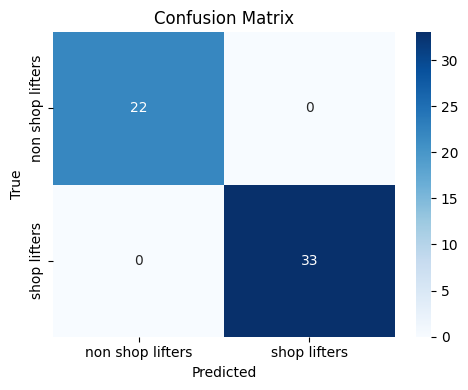

In [17]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [18]:
# Save the model
trainer.save_model("./my_finetuned_model")
# Save the processor
processor.save_pretrained("./my_finetuned_model")

['./my_finetuned_model/preprocessor_config.json']

In [19]:
import shutil

# Zip the folder
shutil.make_archive("my_finetuned_model", 'zip', "./my_finetuned_model")

'/kaggle/working/my_finetuned_model.zip'